# Import Libraries

In [82]:
import numpy as np
import random

from keras.layers import Input, Conv2D, Lambda, Dense, Flatten,MaxPooling2D, concatenate
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import SGD,Adam
from keras.losses import binary_crossentropy

from keras.datasets import mnist

import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from sklearn.manifold import TSNE
from sklearn.svm import SVC
import seaborn as sns
import pandas as pd
from itertools import permutations

# Load Dataset

In [34]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32')/255.0
x_test = x_test.astype('float32')/255.0

x_train_flat = x_train.reshape(-1,784)
x_test_flat = x_test.reshape(-1,784)

In [35]:
from sklearn.preprocessing import LabelBinarizer
le = LabelBinarizer()

y_train_onehot = le.fit_transform(y_train)
y_test_onehot = le.transform(y_test)

##### Scatter Dataset

In [4]:
# Define our own plot function
def scatter(x, labels, fig, position=(1,1,1), subtitle=None):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 10))

    # We create a scatter plot.
    ax = fig.add_subplot(position[0], position[1], position[2])
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[labels.astype(np.int)])

    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in range(10):
        # Position of each label.
        xtext, ytext = np.median(x[labels == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)
        
    if subtitle != None:
        ax.set_title(subtitle)


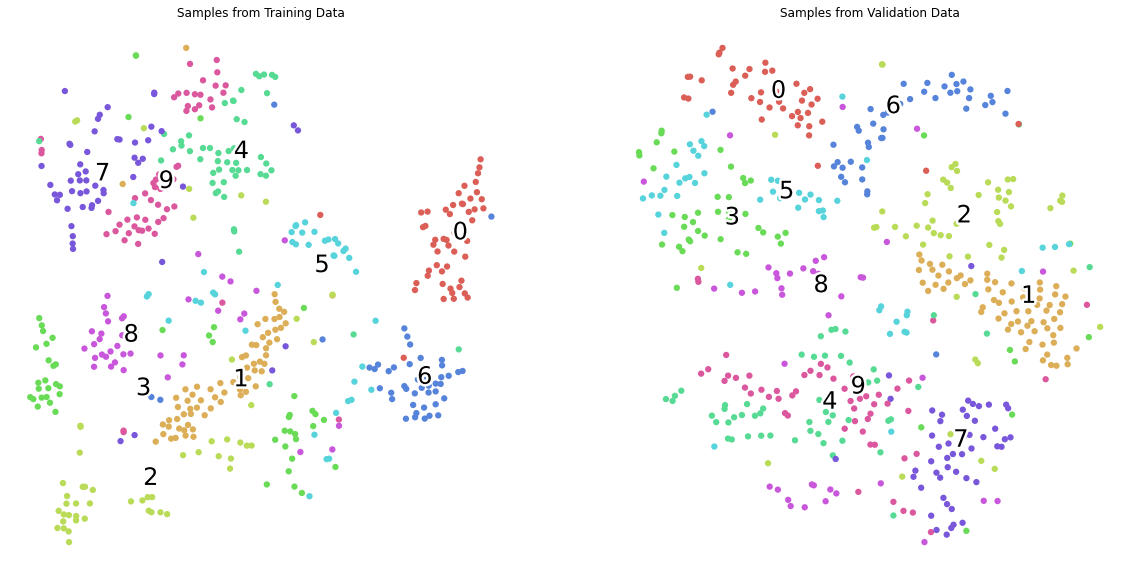

In [5]:
tsne = TSNE()
train_tsne_embeds = tsne.fit_transform(x_train_flat[:512])
eval_tsne_embeds = tsne.fit_transform(x_test_flat[:512])

fig = plt.figure(figsize=(20, 10))
scatter(train_tsne_embeds, y_train[:512], fig, position=(1,2,1), subtitle="Samples from Training Data")
scatter(eval_tsne_embeds, y_test[:512], fig, position=(1,2,2), subtitle="Samples from Validation Data")

# Normal Classifier

In [6]:
Classifier_input = Input((784,))
Classifier_output = Dense(10, activation='softmax')(Classifier_input)
Classifier_model = Model(Classifier_input, Classifier_output)

Instructions for updating:
Colocations handled automatically by placer.


In [7]:
Classifier_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Classifier_model.fit(
    x_train_flat,
    y_train_onehot,
    validation_data=(x_test_flat,y_test_onehot),
    epochs=10
)

Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 8s 137us/step - loss: 0.4631 - acc: 0.8799 - val_loss: 0.3115 - val_acc: 0.9144
Epoch 2/10
60000/60000 [==============================] - 6s 96us/step - loss: 0.3039 - acc: 0.9153 - val_loss: 0.2821 - val_acc: 0.9205
Epoch 3/10
60000/60000 [==============================] - 6s 93us/step - loss: 0.2833 - acc: 0.9209 - val_loss: 0.2711 - val_acc: 0.9245
Epoch 4/10
60000/60000 [==============================] - 6s 98us/step - loss: 0.2731 - acc: 0.9244 - val_loss: 0.2684 - val_acc: 0.9252
Epoch 5/10
60000/60000 [==============================] - 5s 91us/step - loss: 0.2665 - acc: 0.9255 - val_loss: 0.2672 - val_acc: 0.9268
Epoch 6/10
60000/60000 [==============================] - 6s 93us/step - loss: 0.2619 - acc: 0.9271 - val_loss: 0.2709 - val_acc: 0.9259
Epoch 7/10
60000/60000 [==============================] - 5s 89us/step - loss: 

# Classifier with Triplet Loss

### a) Create Datset with triplet-loss type

In [8]:
def generate_triplet(x,y,testsize=0.3,ap_pairs=10,an_pairs=10):
    data_xy = tuple([x,y])

    trainsize = 1-testsize

    triplet_train_pairs = []
    triplet_test_pairs = []
    for data_class in sorted(set(data_xy[1])):

        same_class_idx = np.where((data_xy[1] == data_class))[0]
        diff_class_idx = np.where(data_xy[1] != data_class)[0]
        A_P_pairs = random.sample(list(permutations(same_class_idx,2)),k=ap_pairs) #Generating Anchor-Positive pairs
        Neg_idx = random.sample(list(diff_class_idx),k=an_pairs)
        

        #train
        A_P_len = len(A_P_pairs)
        Neg_len = len(Neg_idx)
        for ap in A_P_pairs[:int(A_P_len*trainsize)]:
            Anchor = data_xy[0][ap[0]]
            Positive = data_xy[0][ap[1]]
            for n in Neg_idx:
                Negative = data_xy[0][n]
                triplet_train_pairs.append([Anchor,Positive,Negative])               
        #test
        for ap in A_P_pairs[int(A_P_len*trainsize):]:
            Anchor = data_xy[0][ap[0]]
            Positive = data_xy[0][ap[1]]
            for n in Neg_idx:
                Negative = data_xy[0][n]
                triplet_test_pairs.append([Anchor,Positive,Negative])    
                
                
                 
    return np.array(triplet_train_pairs), np.array(triplet_test_pairs)

In [9]:
X_train, X_test = generate_triplet(x_train_flat,y_train, ap_pairs=150, an_pairs=150,testsize=0.2)

### b) Triplet_loss function

In [10]:
def triplet_loss(y_true, y_pred, alpha = 0.4):
    """
    Implementation of the triplet loss function
    Arguments:
    y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
    y_pred -- python list containing three objects:
            anchor -- the encodings for the anchor data
            positive -- the encodings for the positive data (similar to anchor)
            negative -- the encodings for the negative data (different from anchor)
    Returns:
    loss -- real number, value of the loss
    """
    print('y_pred.shape = ',y_pred)
    
    total_lenght = y_pred.shape.as_list()[-1]
#     print('total_lenght=',  total_lenght)
#     total_lenght =12
    
    anchor = y_pred[:,0:int(total_lenght*1/3)]
    positive = y_pred[:,int(total_lenght*1/3):int(total_lenght*2/3)]
    negative = y_pred[:,int(total_lenght*2/3):int(total_lenght*3/3)]

    # distance between the anchor and the positive
    pos_dist = K.sum(K.square(anchor-positive),axis=1)

    # distance between the anchor and the negative
    neg_dist = K.sum(K.square(anchor-negative),axis=1)

    # compute loss
    basic_loss = pos_dist-neg_dist+alpha
    loss = K.maximum(basic_loss,0.0)
 
    return loss

### c) Make Clusterer model

In [11]:
def create_base_network(in_dims):
    """
    Base network to be shared.
    """
    #model = Sequential()
    #model.add(Conv2D(128,(7,7),padding='same',input_shape=(in_dims[0],in_dims[1],in_dims[2],),activation='relu',name='conv1'))
    #model.add(MaxPooling2D((2,2),(2,2),padding='same',name='pool1'))
    #model.add(Conv2D(256,(5,5),padding='same',activation='relu',name='conv2'))
    #model.add(MaxPooling2D((2,2),(2,2),padding='same',name='pool2'))
    #model.add(Flatten(name='flatten'))
    #model.add(Dense(4,name='embeddings'))
    
    input_tensor = Input(shape=in_dims)
    x = Conv2D(128,(7,7),padding='same',input_shape=(28,28,1,),activation='relu',name='conv1')(input_tensor)
    x = MaxPooling2D((2,2),(2,2),padding='same',name='pool1')(x)
    x = Conv2D(256,(5,5),padding='same',activation='relu',name='conv2')(x)
    x = MaxPooling2D((2,2),(2,2),padding='same',name='pool2')(x)
    x = Flatten(name='flatten')(x)
    x = Dense(4,name='embeddings')(x)
    model = Model(input_tensor, x)
    
    return model

In [12]:
# tensor_0 : input
anchor_input = Input((28,28,1, ), name='anchor_input')
positive_input = Input((28,28,1, ), name='positive_input')
negative_input = Input((28,28,1, ), name='negative_input')

# layer_0 : Shared embedding layer for positive and negative items
Shared_DNN = create_base_network([28,28,1,])

# tensor_1 : encoded vectors
encoded_anchor = Shared_DNN(anchor_input)
encoded_positive = Shared_DNN(positive_input)
encoded_negative = Shared_DNN(negative_input)

merged_vector = concatenate([encoded_anchor, encoded_positive, encoded_negative], axis=-1, name='merged_layer')

In [13]:
adam_optim = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999)
model = Model(inputs=[anchor_input,positive_input, negative_input], outputs=merged_vector)
model.compile(loss=triplet_loss, optimizer=adam_optim)

model.summary()

y_pred.shape =  Tensor("merged_layer/concat:0", shape=(?, 12), dtype=float32)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor_input (InputLayer)       (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
positive_input (InputLayer)     (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
negative_input (InputLayer)     (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
model_2 (Model)                 (None, 4)            876036      anchor_input[0][0]               
                               

In [14]:
Anchor = X_train[:,0,:].reshape(-1,28,28,1)
Positive = X_train[:,1,:].reshape(-1,28,28,1)
Negative = X_train[:,2,:].reshape(-1,28,28,1)
Anchor_test = X_test[:,0,:].reshape(-1,28,28,1)
Positive_test = X_test[:,1,:].reshape(-1,28,28,1)
Negative_test = X_test[:,2,:].reshape(-1,28,28,1)

Y_dummy = np.empty((Anchor.shape[0],300))
Y_dummy2 = np.empty((Anchor_test.shape[0],1))

history = model.fit([Anchor,Positive,Negative],y=Y_dummy,validation_data=([Anchor_test,Positive_test,Negative_test],Y_dummy2), batch_size=512, epochs=20)
model.save_weights('weights/weights_vectorizer.h5')


Train on 180000 samples, validate on 45000 samples
Epoch 1/20
180000/180000 [==============================] - 46s 253us/step - loss: 0.0354 - val_loss: 0.0266
Epoch 2/20
180000/180000 [==============================] - 41s 225us/step - loss: 9.4905e-04 - val_loss: 0.0250
Epoch 3/20
180000/180000 [==============================] - 41s 225us/step - loss: 2.3091e-04 - val_loss: 0.0216
Epoch 4/20
180000/180000 [==============================] - 40s 224us/step - loss: 8.8306e-05 - val_loss: 0.0244
Epoch 5/20
180000/180000 [==============================] - 41s 227us/step - loss: 6.7621e-05 - val_loss: 0.0200
Epoch 6/20
180000/180000 [==============================] - 41s 230us/step - loss: 5.5001e-05 - val_loss: 0.0232
Epoch 7/20
180000/180000 [==============================] - 41s 227us/step - loss: 1.0239e-04 - val_loss: 0.0263
Epoch 8/20
180000/180000 [==============================] - 41s 228us/step - loss: 1.4218e-04 - val_loss: 0.0239
Epoch 9/20
180000/180000 [=======================

### d) Check the results

In [15]:
#model.save_weights('weights/weights_vectorizer.h5')
trained_model = Model(inputs=anchor_input, outputs=encoded_anchor)
trained_model.load_weights('weights/weights_vectorizer.h5')

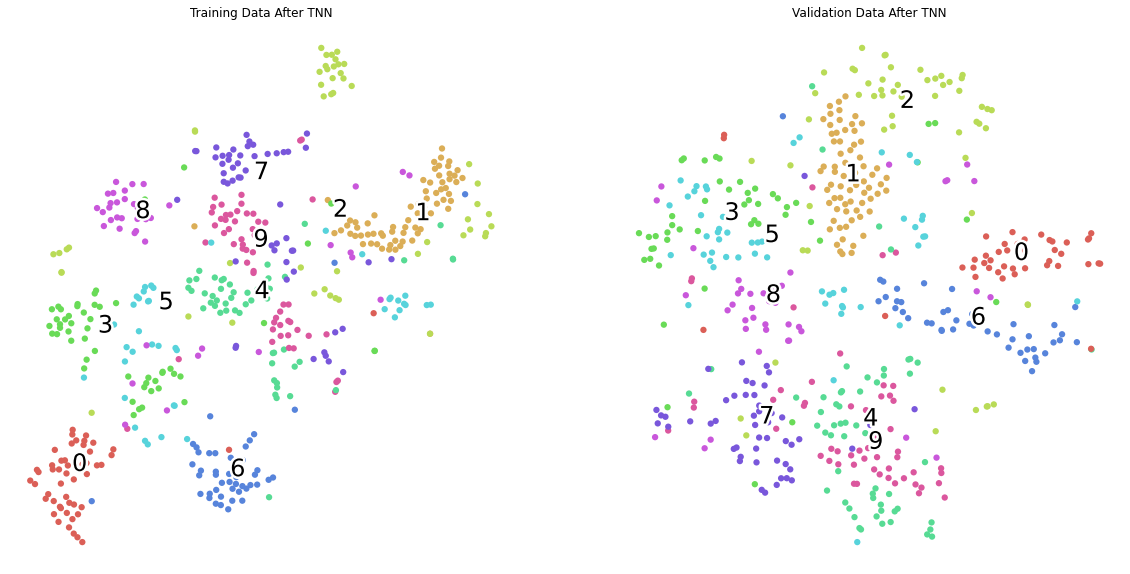

In [16]:
X_train_trm = trained_model.predict(x_train[:512].reshape(-1,28,28,1))
X_test_trm = trained_model.predict(x_test[:512].reshape(-1,28,28,1))

tsne = TSNE()
train_tsne_embeds = tsne.fit_transform(X_train_trm)
eval_tsne_embeds = tsne.fit_transform(X_test_trm)

fig = plt.figure(figsize=(20, 10))

train_tsne_embeds = tsne.fit_transform(x_train_flat[:512])
eval_tsne_embeds = tsne.fit_transform(x_test_flat[:512])
scatter(train_tsne_embeds, y_train[:512], fig, position=(1,2,1), subtitle="Training Data After TNN")
scatter(eval_tsne_embeds, y_test[:512], fig, position=(1,2,2), subtitle="Validation Data After TNN")

### e) make classifier

In [71]:
centers = []
for label in range(10):
    idxs = np.where(y_train==label)
    centers.append(np.sum(X_train_trm[idxs], axis=0) / len(idxs[0]))
    
centers_df = pd.DataFrame(centers)
centers_df.to_csv('centers.csv','\t')